# **Module 3: Raster Data in Python**

In [1]:
# general use packages
import numpy as np
import matplotlib.pyplot as plt

# geospatial packages
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.transform import Affine
import rasterio.mask
from rasterstats import zonal_stats
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import xarray as xr
from xrspatial.convolution import circle_kernel
from xrspatial.focal import focal_stats
from xrspatial.zonal import stats

## **Exercises**
Your expercises will draw on datasets from the Spatial Production Allocation Model (SPAM) and Minnesota Geospatial Commons, which have been downloaded, cleaned, transformed, and saved to the directory `./data-module-3/` for this workshop.
### Data
- `spam_H_MAIZ_A_mn.tif` (crop harvested area), `spam_P_MAIZ_A_mn.tif` (crop production) - agricultural indicators at 10x10km grid-cell resolution from MAPSPAM (Spatial Production Allocation Model) data center  https://www.mapspam.info/data/
- `gw_provinces_extra.shp` - Groundwater Provinces of Minnesota derived from  https://gisdata.mn.gov/dataset/geos-groundwater-provinces-mn

**Question 1. Open raster files `spam_H_MAIZ_A_mn.tif` and `spam_P_MAIZ_A_mn.tif` and check their properties: Coordinate Reference System, extent, resolution, NoData, and transform .** 

In [2]:
spam_h = rasterio.open("./data-module-3/spam_H_MAIZ_A_mn.tif")
print ("Dataset CRS is {}".format(spam_h.crs))
print ("Dataset extent is {}".format(spam_h.bounds))
print ("Dataset resolution is {}".format(spam_h.res))
print ("Dataset NoData is {}".format(spam_h.nodata))
print ("Dataset tranform is")
spam_h.transform

Dataset CRS is EPSG:4326
Dataset extent is BoundingBox(left=-97.250331, bottom=43.500186, right=-89.500362, top=49.416829)
Dataset resolution is (0.08333300000000007, 0.083333)
Dataset NoData is -3.3999999521443642e+38
Dataset tranform is


Affine(0.08333300000000007, 0.0, -97.250331,
       0.0, -0.083333, 49.416829)

In [3]:
spam_p = rasterio.open("./data-module-3/spam_P_MAIZ_A_mn.tif")
print ("Dataset CRS is {}".format(spam_p.crs))
print ("Dataset extent is {}".format(spam_p.bounds))
print ("Dataset resolution is {}".format(spam_p.res))
print ("Dataset NoData is {}".format(spam_p.nodata))
print ("Dataset tranform is")
spam_p.transform

Dataset CRS is EPSG:4326
Dataset extent is BoundingBox(left=-97.250331, bottom=43.500186, right=-89.500362, top=49.416829)
Dataset resolution is (0.08333300000000007, 0.083333)
Dataset NoData is -3.3999999521443642e+38
Dataset tranform is


Affine(0.08333300000000007, 0.0, -97.250331,
       0.0, -0.083333, 49.416829)

**Question 2. Read datasets from the previous question as arrays, reset NoData values, and plot them.**

In [4]:
spam_h_array = spam_h.read(1)
spam_h_array[spam_h_array==spam_h.nodata]=np.nan
spam_p_array = spam_p.read(1)
spam_p_array[spam_p_array==spam_p.nodata]=np.nan

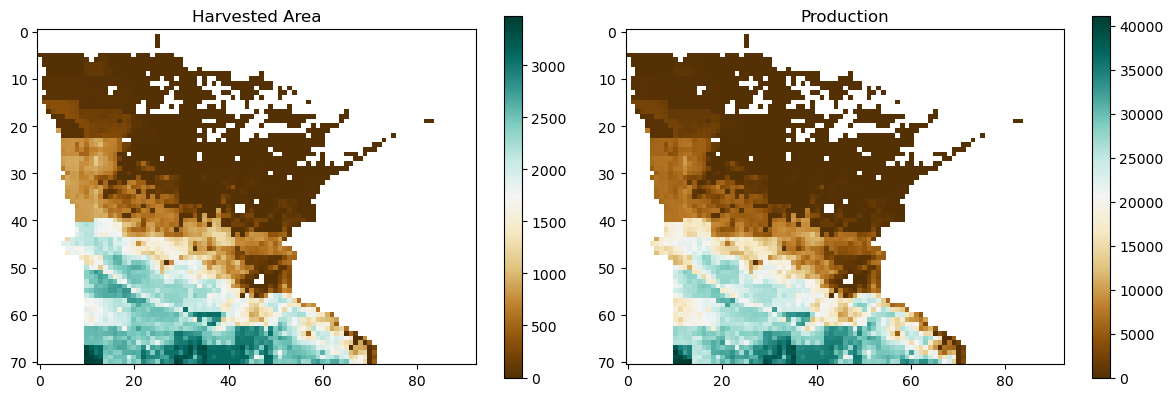

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
plot0 = axs[0].imshow(spam_h_array, cmap="BrBG")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("Harvested Area")
plot1 = axs[1].imshow(spam_p_array, cmap="BrBG")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("Production")
plt.tight_layout()

**Question 3. Calculate a ratio of Production raster to Harvested Area to create an array Yield. Find statistics: maximum Yield and its standard deviation.**

In [6]:
spam_y_array = spam_p_array/spam_h_array
print ("Maximum Yield is {}".format(np.nanmax(spam_y_array)))
print ("Standard Deviation of Yield is {}".format(np.nanstd(spam_y_array)))

Maximum Yield is 14.12733268737793
Standard Deviation of Yield is 1.6627368927001953


/tmp/ipykernel_4245/937731917.py:1: RuntimeWarning: invalid value encountered in divide
  spam_y_array = spam_p_array/spam_h_array


**Question 4. Reclassify Yield array by using 3 categories (make your own breaks). Plot both for comparison.**

In [7]:
reclassified = spam_y_array.copy()
reclassified[(reclassified > 0) & (reclassified <= 8)] = 1
reclassified[(reclassified > 8) & (reclassified <= 10)] = 2
reclassified[(reclassified > 10)] = 3

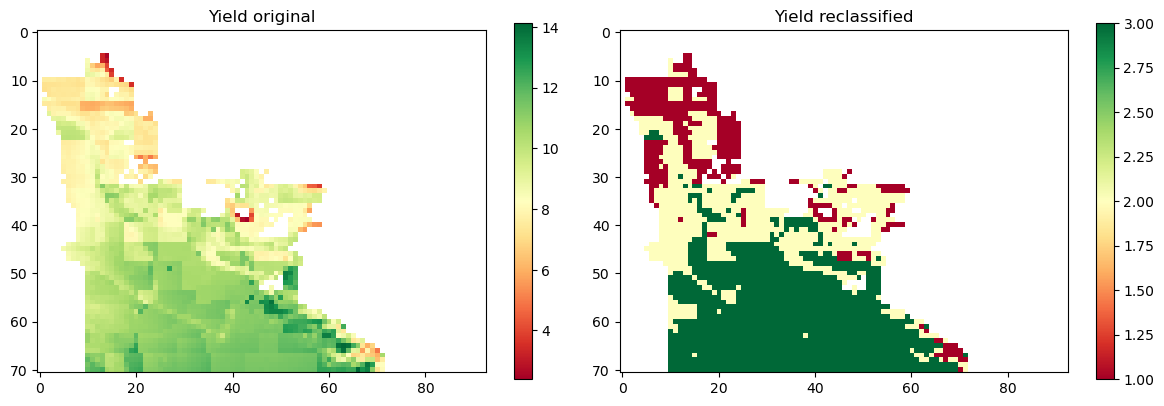

In [8]:
fig, axs = plt.subplots(1,2,  figsize=(12,4))
plot0 = axs[0].imshow(spam_y_array, cmap="RdYlGn")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("Yield original")
plot1 = axs[1].imshow(reclassified, cmap="RdYlGn")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("Yield reclassified")
plt.tight_layout()

**Question 5: Resample Production raster to a coarser resolution. Plot both for comparison**

In [9]:
scale_factor = 1/2
with rasterio.open("./data-module-3/spam_P_MAIZ_A_mn.tif") as dataset:
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor),
            int(dataset.width * scale_factor)
        ),
        resampling=Resampling.nearest
    )
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
aggregated = data[0]
aggregated[aggregated==dataset.nodata]=np.nan

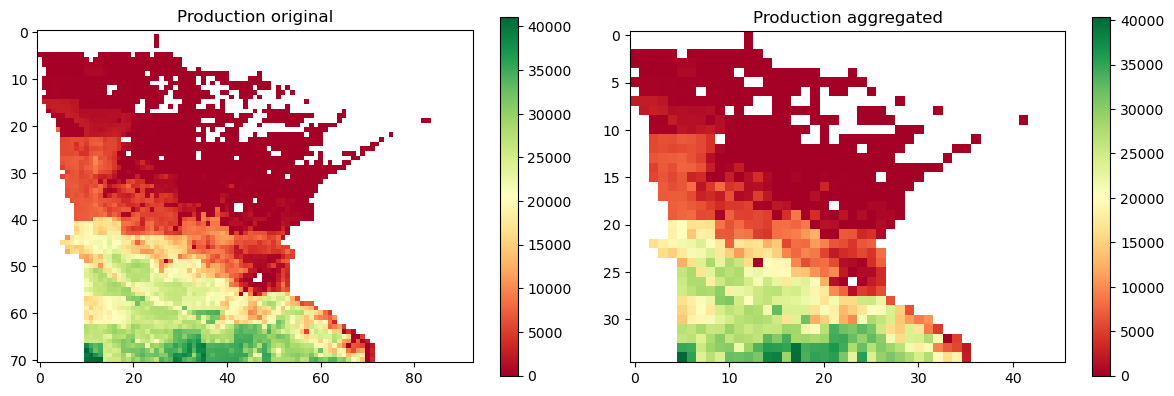

In [10]:
fig, axs = plt.subplots(1,2,  figsize=(12,4))
plot0 = axs[0].imshow(spam_p_array, cmap="RdYlGn")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("Production original")
plot1 = axs[1].imshow(aggregated, cmap="RdYlGn")
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("Production aggregated")
plt.tight_layout()

**Question 6. Use focal statistics function on Yield array to create an array which shows the mean yield within 3x3 neighborhood grid cells. Then create a raster map that displays the difference between each grid cell's Yield and "mean" Yield of its neighborhood. Plot the original raster, raster with focal statistics applied, and their difference raster as 3 subplots on the same figure.**

In [11]:
spam_y_xr =  xr.DataArray(spam_y_array, dims=["y", "x"], name="yield")
kernel = np.ones([3,3])
spam_y_xr_focal = focal_stats(spam_y_xr, kernel, stats_funcs=["mean"])[0]
difference  = spam_y_xr - spam_y_xr_focal

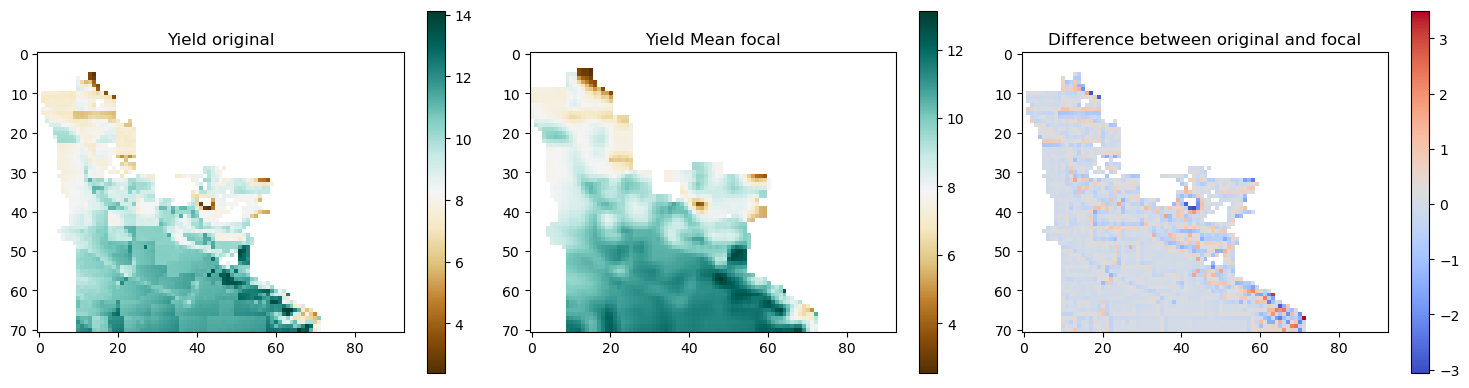

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plot0 = axs[0].imshow(spam_y_xr, cmap="BrBG")
fig.colorbar(plot0, ax=axs[0])
axs[0].set_title("Yield original")
plot1 = axs[1].imshow(spam_y_xr_focal, cmap="BrBG") 
fig.colorbar(plot1, ax=axs[1])
axs[1].set_title("Yield Mean focal")
plot2 = axs[2].imshow(difference, cmap="coolwarm") 
fig.colorbar(plot2, ax=axs[2])
axs[2].set_title("Difference between original and focal")
plt.tight_layout()

**Question 7. Open `gw_provinces_extra.shp`. Change the CRS of the polygon data to the CRS of the Production raster dataset. Select polygons with `PROVINCE` 1, 2, and 3 for further analysis.** 

In [13]:
gw_provinces_gdf = gpd.read_file("./data-module-3/gw_provinces_extra.shp")
print ("Coordinate system is {}".format(gw_provinces_gdf.crs))
gw_provinces_gdf = gw_provinces_gdf.to_crs(spam_p.crs)
subset = gw_provinces_gdf[(gw_provinces_gdf.PROVINCE == "1")|(gw_provinces_gdf.PROVINCE == "2")|(gw_provinces_gdf.PROVINCE == "3")]

Coordinate system is EPSG:26915


<Axes: >

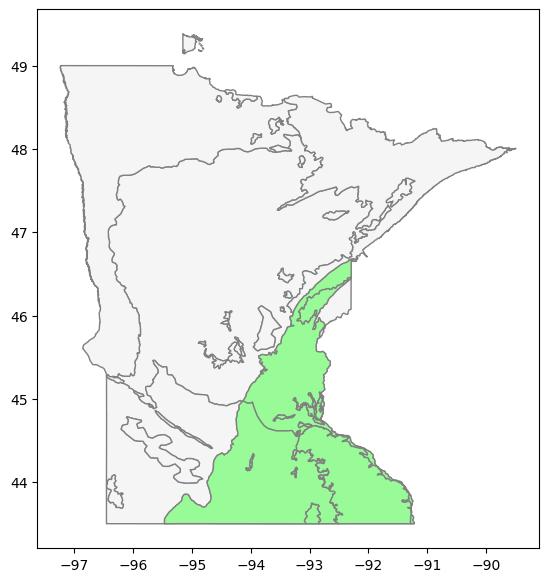

In [14]:
fig, ax = plt.subplots(figsize=(14,7))
gw_provinces_gdf.plot(ax=ax, color="whitesmoke", edgecolor="grey")
subset.plot(ax=ax, color="palegreen", edgecolor="grey")

**Question 8. Calculate zonal statistics for selected geometries as `sum` of Production raster. Dissolve `production` column by `PROVINCE`.**

In [15]:
subset_stats = subset.copy()
subset_stats["production"] = subset_stats.apply(lambda x: zonal_stats(x.geometry, spam_p_array, affine=spam_p.transform, 
                                                            nodata=spam_p.nodata, stats =["sum"])[0]["sum"], axis=1)
summary = subset_stats[["PROVINCE", "geometry", "production"]].dissolve(by="PROVINCE", aggfunc="sum")
summary

,geometry,production
PROVINCE,,
1,"POLYGON ((-92.19250 46.67675, -92.19540 46.674...",1.042444e+06
2,"POLYGON ((-94.05317 44.94802, -94.05124 44.948...",8.891432e+06
3,"MULTIPOLYGON (((-93.23199 44.09599, -93.22710 ...",3.595048e+06
